# Inference Gym Tutorial

##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/spinoffs/inference_gym/notebooks/inference_gym_tutorial.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/spinoffs/inference_gym/notebooks/inference_gym_tutorial.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/tensorflow/probability/main/spinoffs/inference_gym/notebooks/inference_gym_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Introduction

Probabilistic modeling and inference is a commonly used methodology in data science. A lot of progress has been made in the development of generic and reliable inference algorithms, but the question is far from solved and many new publications are made each year. An important component of such methodological research is validation of the proposed algorithm on a set of representative problems. Inference Gym aims to fulfill that niche by providing a varied set of such problems that can be used to develop, debug and compare novel and established inference algorithms. This tutorial will introduce the API of the packaged models and illustrate how to build a probabilistic inference algorithm to do inference on one such model.

# Setup and imports

First, we will install the Inference Gym from PyPi, as well as some supporting libraries. Inference Gym comes with multiple backends: JAX, NumPy and TensorFlow. For this tutorial we'll be using JAX, but using TensorFlow would work just as well. Using the NumPy backend locks you out of automatic differentiation support, necessary for certain inference algorithms.

In [0]:
!pip install inference_gym tfds_nightly tf-nightly tfp_nightly[jax] pandas arviz

To select a backend, we import the appropriate module. E.g. to select the JAX backend, we import Inference Gym like this::

```python
import inference_gym.using_jax as gym
```

If we wanted TensorFlow or NumPy, we'd import `using_tensorflow` or `using_numpy` respectively.

One dependency of note is TensorFlow Datasets, which is used for some of the models that are conditioned on real-world data. It is, however, optional, if all you're interested in are synthetic benchmarks.

In [0]:
import functools

import inference_gym.using_jax as gym
import jax
from jax import lax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

jax.config.update('jax_enable_x64', True)

# Exploring the Inference Gym

Let's explore what models are available. We'll iterate through the `gym.targets` module and grab all the models that can be instantiated without any additional configuration. We'll make a small table showing all such targets, and the number of latent variables they have.

In [0]:
#@title `get_zero_conf_targets` + `get_num_latents` implementation
def get_zero_conf_targets():
  targets = {}
  for target_name in gym.targets.__all__:
    try:
      targets[target_name] = getattr(gym.targets, target_name)()
    except:
      pass
  return targets

def get_num_latents(target):
  return int(sum(map(np.prod, list(jax.tree.flatten(target.event_shape)[0]))))

In [0]:
zero_conf_targets = get_zero_conf_targets()

In [0]:
pd.DataFrame([[str(t), get_num_latents(t)] for t in zero_conf_targets.values()], columns=['Pretty Name', 'Number of Latents'], index=zero_conf_targets.keys())

,Pretty Name,Number of Latents
Banana,Banana,2
BrownianMotionMissingMiddleObservations,Brownian Motion Missing Middle Observations,30
BrownianMotionUnknownScalesMissingMiddleObservations,Brownian Motion with Unknown Scales,32
ConvectionLorenzBridge,Ambrogioni Lorenz System,90
ConvectionLorenzBridgeUnknownScales,Ambrogioni Lorenz System,92
EightSchools,Eight Schools,10
GermanCreditNumericLogisticRegression,German Credit Numeric Logistic Regression,25
GermanCreditNumericProbitRegression,German Credit Numeric Probit Regression,25
GermanCreditNumericSparseLogisticRegression,German Credit Numeric Sparse Logistic Regression,51
IllConditionedGaussian,Ill-Conditioned Gaussian,100


# Basic model properties

Let's take a closer look at one of the models in the Inference Gym. We'll choose the `GermanCreditNumericSparseLogisticRegression`, as it's a relatively challenging model with interesting structure. Note that this tutorial is written to be generic as far as the exact model chosen, so after you're done reading it the first time, you could experiment with other models.

In [0]:
target = gym.targets.GermanCreditNumericSparseLogisticRegression()

As with any Python class, we can take a look at its docstring.

In [0]:
print(type(target).__doc__)
print(super(type(target), target).__doc__)

Bayesian logistic regression with a sparsity-inducing prior.

  This model uses the German Credit (numeric) data set [1].

  #### References

  1. https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
  
Bayesian logistic regression with a sparsity-inducing prior.

  ```none
  global_scale ~ Gamma(0.5, 0.5)

  # The `+ 1` is for the bias term.
  for i in range(num_features + 1):
    unscaled_weights[i] ~ Normal(loc=0, scale=1)
    local_scales[i] ~ Gamma(0.5, 0.5)
    weights[i] = unscaled_weights[i] * local_scales[i] * global_scale

  for j in range(num_datapoints):
    label[j] ~ Bernoulli(logit=concat([features[j], [1]) @ weights)
  ```
  


All models in the Inference Gym are instances of the `Model` class. Some, including this one, are also instances of the `BayesianModel` class with some additional properties we won't go in to (see Appendix A). Let's go through the properties common to all models.

The primary functionality of an Inference Gym `Model` is the `unnormalized_log_prob` function which evaluates the unnormalized log density of the model. However, to invoke it we need to be able to construct a valid point in its support. To allow this, Inference Gym models provide various descriptiors of their random variables. First, there is the `dtype`, which encompasses both the structure (in the sense of potentially nested Python collections), as well as the numerical type. In this case, we have 3 sets of random variables, all consisting of floating point tensors.

In [0]:
target.dtype

{'global_scale': numpy.float32,
 'local_scales': numpy.float32,
 'unscaled_weights': numpy.float32}

We see that there are 3 named random variables. Each random variable could be a scalar, vector or higher ranked tensor. We can extract the shape of each variable via the `event_shape` property.

In [0]:
target.event_shape

{'global_scale': TensorShape([]),
 'local_scales': TensorShape([25]),
 'unscaled_weights': TensorShape([25])}

This means that `global_scale` is a scalar and `local_scales` and `unscaled_weights` are both vectors of length 25.

In many models the random variables are only supported on subsets of $\mathbb{R}^n$. The Inference Gym does not expose this information directly. Instead, it provides invertible maps that map from the "unconstrained" space of $\mathbb{R}^m$ (where $m \ne n$ in general) to the support of the model. In this case, we see that the first two random variables get the `Exp` bijector, which means that those two variables need to be constrained to be positive when doing inference.

In [0]:
target.default_event_space_bijector

{'global_scale': <tensorflow_probability.substrates.jax.bijectors.exp.Exp at 0x7ff7bc6b8450>,
 'local_scales': <tensorflow_probability.substrates.jax.bijectors.exp.Exp at 0x7ff7bc6b8c10>,
 'unscaled_weights': <tensorflow_probability.substrates.jax.bijectors.identity.Identity at 0x7ff7bc6b8650>}

Now, we can finally invoke the `unnormalized_log_prob` function. We'll use all the properties we've presented so far to construct a valid point where we can evaluate the log density. We'll use JAX's `tree_util.tree_multimap` which is a generalization of Python's `map` function that works on all sorts of nested (and not-nested) Python collections. We certainly could have used a dict-comprehension here, but we'll do it this way in case you want to try out different targets.

We need to do a small dance with shapes when constructing the unconstrained values, since the `default_event_space_bijector` is allowed to alter the shape of the tensor it operates on. Luckily, it provides the `inverse_event_shape` method, which allows us to compute the required shape.

Last thing to note is that for this model, the first time you call `unnormalized_log_prob`, it'll load the dataset, so it will take a little while just this one time.

In [0]:
def nested_zeros(shape, dtype):
  return jax.tree_multimap(lambda d, s: jnp.zeros(s, d), dtype, shape)

z = jax.tree_multimap(lambda d, b, s: nested_zeros(b.inverse_event_shape(s), d),
                      target.dtype, target.default_event_space_bijector, target.event_shape)
print('Unconstrained=', z)
x = jax.tree_multimap(lambda z, b: b(z), z, target.default_event_space_bijector)
print('Constrained=', x)
print(target.unnormalized_log_prob(x))

Unconstrained= {'global_scale': DeviceArray(0., dtype=float32), 'local_scales': DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'unscaled_weights': DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}
Constrained= {'global_scale': DeviceArray(1., dtype=float32), 'local_scales': DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), 'unscaled_weights': DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}


Dataset german_credit_numeric downloaded and prepared to /root/tensorflow_datasets/german_credit_numeric/1.0.0. Subsequent calls will reuse this data.
-753.0135


Note the convention of using `z` as a point in the unconstrained space, and `x` being the corresponding point in the model's support. We'll be using this convention throughout this tutorial.

The last feature we'll cover are the sample transformations. These are functions which transform samples from the model into a form we typically care about. This lets us decouple the details of specifying the probabilistic form of the model from the, e.g. physical, quantities we're trying to infer. Most models have an `identity` sample transformation which returns the parameters in some standard form. In this model, it returns them unchanged:

In [0]:
target.sample_transformations['identity'](x)

{'global_scale': DeviceArray(1., dtype=float32),
 'local_scales': DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
              1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 'unscaled_weights': DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}

Sample transformations are, when possible, also annotated with ground truth statistics, such as the mean and standard deviation under the model's distribution. These quantities can be used to validate the accuracy of an inference algorithm:

In [0]:
identity_fn = target.sample_transformations['identity']
print('E[f(x)]', identity_fn.ground_truth_mean)
print('StdDev[f(x)]', identity_fn.ground_truth_standard_deviation)

E[f(x)] {'unscaled_weights': array([-1.18744588,  1.03846458, -1.00745144,  0.39961211, -0.97756226,
       -0.63471018, -0.60607722,  0.00500732,  0.66134958, -0.42657012,
       -0.79533339,  0.33168098,  0.04796292, -0.34821729, -0.81735248,
        0.89536281, -0.88346099,  0.6783477 ,  0.62783991,  0.46108267,
       -0.39470336, -0.19014941, -0.02970322,  0.00213633, -1.34637015]), 'local_scales': array([2.4634903 , 1.7887786 , 1.65631361, 0.55192067, 1.53945456,
       0.75996061, 0.70365708, 0.34192756, 0.82864484, 0.54023153,
       0.99413778, 0.46594351, 0.33472228, 0.46686652, 1.11383317,
       1.24846549, 1.2493555 , 0.90027626, 0.82035648, 0.62206757,
       0.58713199, 0.36754782, 0.35208056, 0.34878029, 3.29251999]), 'global_scale': array(0.34659074)}
StdDev[f(x)] {'unscaled_weights': array([0.56883513, 0.56479472, 0.56132007, 0.784472  , 0.56120848,
       0.69200064, 0.6955933 , 0.81783818, 0.68972135, 0.76754381,
       0.60445531, 0.78898268, 0.81665804, 0.7828087 

In many cases, the ground truth values are estimated using long-run MCMC chains, so they come with associated standard errors.

In [0]:
print('SEM', identity_fn.ground_truth_mean_standard_error)

SEM {'unscaled_weights': array([0.00064578, 0.0006674 , 0.00067386, 0.00082031, 0.00066152,
       0.00083002, 0.00087636, 0.0007809 , 0.00081023, 0.00080793,
       0.00074986, 0.00081407, 0.00080463, 0.00081471, 0.00073708,
       0.00068195, 0.00069805, 0.00091732, 0.00094708, 0.00088724,
       0.00085964, 0.0007783 , 0.00080544, 0.00078171, 0.00070469]), 'local_scales': array([0.00176417, 0.00151648, 0.00142428, 0.00085792, 0.00133294,
       0.00101305, 0.00115227, 0.00058793, 0.00108931, 0.00081674,
       0.00119843, 0.00073369, 0.00062113, 0.00076704, 0.00112916,
       0.00132339, 0.00121219, 0.00132546, 0.00119993, 0.00094363,
       0.00099183, 0.00067729, 0.00060173, 0.00065974, 0.00247683]), 'global_scale': array(0.00027275)}


# `VectorModel` adapter

While the organizing random variables in Python collections is great for interpretability of a model, it can get in the way when experimenting with new inference algorithms. To aid this use case, Inference Gym provides an adapter called the `VectorModel`. This converts any model to have a single, vector-valued random variable. We'll be using it throughout the rest of this tutorial.

In [0]:
target = gym.targets.VectorModel(target, flatten_sample_transformations=True)
print('dtype=', target.dtype)
print('event_shape=', target.event_shape)
print('default_event_space_bijector=', target.default_event_space_bijector)

dtype= <class 'numpy.float32'>
event_shape= (51,)
default_event_space_bijector= <tensorflow_probability.substrates.jax.bijectors.blockwise.Blockwise object at 0x7ff7bc684890>


# Example: Writing an Inference Algorithm

Let us now illustrate the use of an Inference Gym model by writing a simple inference procedure: Hamiltonian Monte Carlo (HMC) initialized at the maximum a posteriori (MAP) estimate.

## Computing the MAP estimate

First, let's start with computing the MAP estimate, which is a standard procedure for initializing HMC. It doesn't always work (some challenging models have their modes at infinity), but it's good enough for this example.

We define the MAP objective function. Since we'll be using a simple gradient descent-based method to perform this optimization, we need some way to constrain the model parameters within their supports. We'll do this by doing the optimization in an unconstrained $\mathbb{R}^n$ space, and then mapping from that space to the model's support. Here the `default_event_space_bijector` function is useful.

In [0]:
def map_objective_fn(z):
  x = target.default_event_space_bijector(z)
  return -target.unnormalized_log_prob(x)

When using TensorFlow and JAX backends, Inference Gym models with continuous parameters are typically amenable to automatic differentiation. We'll use JAX's `grad` functionality to create a function that computes the gradient of our MAP objective.

In [0]:
map_objective_grad_fn = jax.grad(map_objective_fn)

Now, let's use a simple gradient descent implementation to find the MAP estimate.

In [0]:
#@title `optimize` implementation
def optimize(z_init, objective_fn, objective_grad_fn, learning_rate, num_steps):
  def opt_step(z):
    objective = objective_fn(z)
    z = z - learning_rate * objective_grad_fn(z)
    return z, objective
  
  return jax.lax.scan(lambda z, _: opt_step(z), init=z_init,
                      xs=None, length=num_steps)

In [0]:
z_map, objective_trace = optimize(
  z_init=jnp.zeros(target.default_event_space_bijector.inverse_event_shape(target.event_shape)),
  objective_fn=map_objective_fn,
  objective_grad_fn=map_objective_grad_fn,
  learning_rate=0.001,
  num_steps=200,
)

If we plot the loss, it would appear that the algorithm has converged.

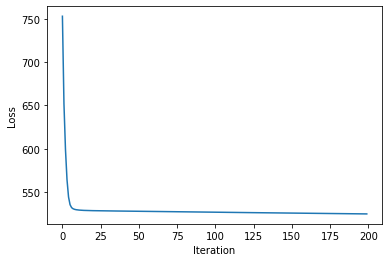

In [0]:
plt.plot(objective_trace)
plt.ylabel('Loss')
plt.xlabel('Iteration');

Since we have the ground truths, we can compare the MAP estimate to the true expectation.

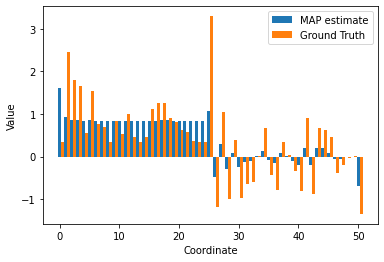

In [0]:
identity_fn = target.sample_transformations['identity']
x_map = target.default_event_space_bijector(z_map)
x_map_transformed = identity_fn(x_map)
plt.bar(jnp.arange(x_map_transformed.shape[-1]), x_map_transformed, 0.5, label='MAP estimate')
plt.bar(0.5 + jnp.arange(x_map_transformed.shape[-1]), identity_fn.ground_truth_mean, 0.5, label='Ground Truth')
plt.ylabel('Value')
plt.xlabel('Coordinate')
plt.legend();

Kind of close, but clearly not the same. Additionally, the MAP estimate does not give us any indication of the spread of the posterior. Let us move on to implementing a less biased inference algorithm.

## Running HMC

[Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434) is a powerful algorithm for performing inference on densities with continuous support. Like with the MAP optimization, it works best on unconstrained spaces, so when writing the log density function, we need to write it to operate in the constrained space. Here the task is slightly more complex, as when changing the parameterization of a density for the purpose of doing probabilistic inference on it, we need to keep track of the change in volume induced by the transformation. Mathematically,

\begin{align*}
P(z = z) = P(x = f(z)) \left|\det \frac{\mathrm{d} f(z)}{\mathrm{d} z} \right|
\end{align*}

where `f(z)` is a function that goes from the unconstrained space to the constrained space. Fortunately, this is easy to implement using the `default_event_space_bijector` property, as it provides the log-determinant of the Jacobian, coutesy of the TensorFlow Probability library.

In [0]:
def target_log_prob_fn(z):
  x = target.default_event_space_bijector(z)
  return (target.unnormalized_log_prob(x) + 
          target.default_event_space_bijector.forward_log_det_jacobian(z, event_ndims=1))

We'll also need the gradient of `target_log_prob_fn`, which we'll again derive via autodiff.

In [0]:
target_log_prob_grad_fn = jax.grad(target_log_prob_fn)

Now, we can use these objects to drive a gradient-based inference algorithm like HMC. We provide a small implementation here for exposition purposes, but Inference Gym models integrate well with black box inference frameworks, like TensorFlow Probability (see Appendix B).

In [0]:
#@title `hmc` implementation
def hmc(z_init, target_log_prob_fn, target_log_prob_grad_fn,
        step_size, num_leapfrog_steps, num_steps, key):
  def leapfrog_step(state_momentum):
    state, momentum = state_momentum
    momentum = momentum + 0.5 * step_size * target_log_prob_grad_fn(state)
    state = state + momentum * step_size
    momentum = momentum + 0.5 * step_size * target_log_prob_grad_fn(state)
    return state, momentum

  @jax.jit
  def hmc_step(state_key):
    init_state, key = state_key
    key, momentum_key, jitter_key, metropolis_hastings_key = jax.random.split(key, 4)

    init_momentum = jax.random.normal(momentum_key, init_state.shape, init_state.dtype)
    init_energy = -target_log_prob_fn(init_state) + 0.5 * (init_momentum**2).sum()
    cur_num_leapfrog_steps = jax.random.randint(jitter_key, [], 1, num_leapfrog_steps * 2)

    new_state, new_momentum = lax.fori_loop(0, cur_num_leapfrog_steps, 
        lambda _, state_momentum: leapfrog_step(state_momentum), (init_state, init_momentum))

    new_energy = -target_log_prob_fn(new_state) + 0.5 * (new_momentum**2).sum()

    energy_change = new_energy - init_energy
    diverged = energy_change > 1000
    p_accept = jnp.exp(jnp.minimum(0, -energy_change))
    p_accept = jnp.where(jnp.isfinite(p_accept), p_accept, 0.)
    is_accepted = jax.random.bernoulli(metropolis_hastings_key, p_accept)
    state = jnp.where(is_accepted, new_state, init_state)

    return (state, key), (state, is_accepted, diverged)
  
  # Use SIMD to run multiple chains at once.
  @jax.vmap
  def batched_hmc(state_key, _):
    return hmc_step(state_key)
  
  _, (z_chain, is_accepted, diverged) = lax.scan(batched_hmc, init=(z_init, key), xs=None, length=num_steps)

  return z_chain, is_accepted, diverged

In [0]:
num_steps = 4000
step_size = 0.03
num_leapfrog_steps = 100
num_chains = 4

z_init = z_map + jnp.zeros((num_chains,) + target.event_shape, target.dtype)
key = jax.random.split(jax.random.PRNGKey(1), num_chains)

z_chain, is_accepted, diverged = hmc(
    z_init=z_init,
    target_log_prob_fn=target_log_prob_fn,
    target_log_prob_grad_fn=target_log_prob_grad_fn,
    step_size=step_size,
    num_leapfrog_steps=num_leapfrog_steps,
    num_steps=num_steps,
    key=key)
x_chain = target.default_event_space_bijector(z_chain)

As the first diagnostic, we'll measure the acceptance probability. The theory suggests the optimal value is `0.651`, but since we know this is a challenging problem we'll pick the hyperparameters such that we get something higher. Note that you'll need to adjust these hyperparmeters if you use a different model.

In [0]:
# This will take awhile because JAX stages computation asynchronously.
print('P(accept)', is_accepted[num_steps//2:].mean())

P(accept) 0.928125


Another useful diagnostic is the number of divergences. A divergence is when HMC proposes a proposal with an extremely low probability of acceptance. Divergences indicate that HMC is struggling with some part of the geometry, and can bias the Monte Carlo averages. For the purposes of computing those averages, we don't care about divergences that happen during warmup iterations, which we will discard. In this case, even after discarding warmup, we get a few divergences indicating that this is a challenging problem. We could remove some of them by reducing the step size.

In [0]:
print('num divergences', diverged[num_steps//2:].sum())

num divergences 10


Now, let's use the Arviz library to do some more analysis.

In [0]:
# Arviz expects traces to have the shape[num_chains, num_steps, num_dims], so
# we need to do a transpose. We'll also discard the first half of the samples
# for warmup.

az_data = az.from_dict(
    posterior=dict(x=x_chain[num_steps//2:].transpose((1, 0, 2))),
    sample_stats=dict(diverging=diverged[num_steps//2:].transpose((1, 0))),
)

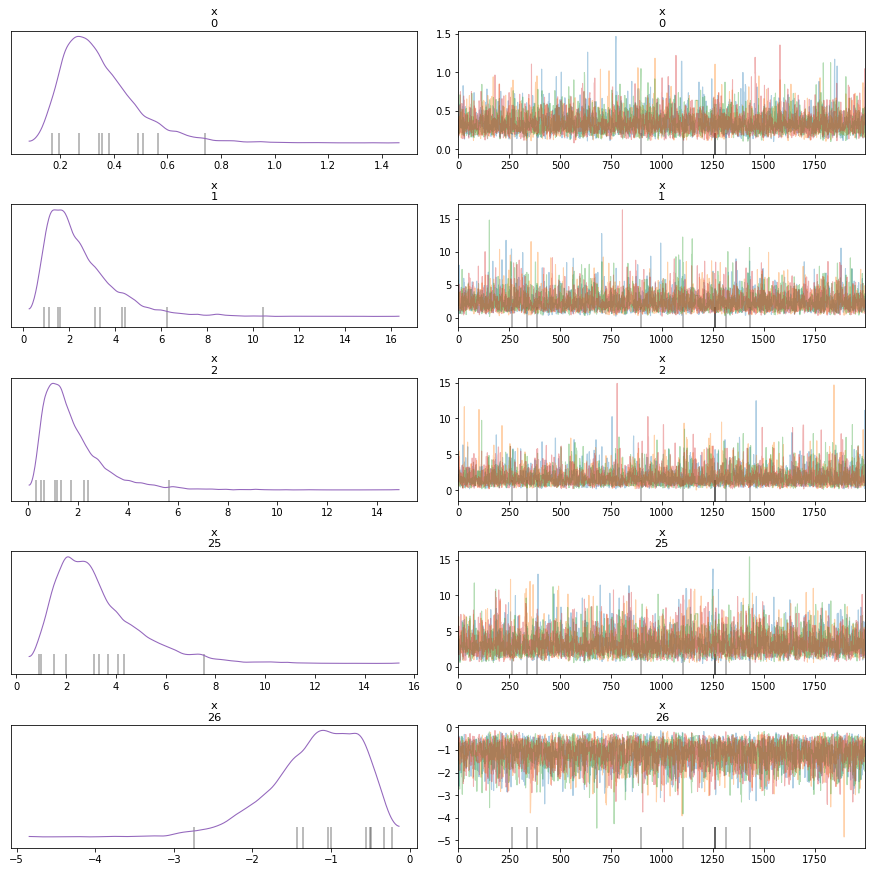

In [0]:
interesting_dims = {'x_dim_0': [0, 1, 2, 25, 26]}
az.plot_trace(az_data, combined=True, compact=False, coords=interesting_dims, figsize=(12, 12));

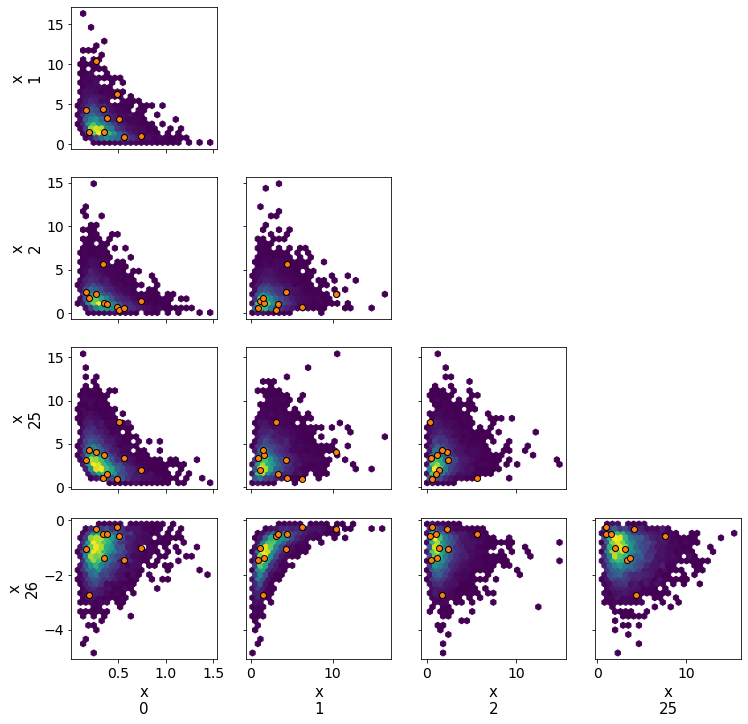

In [0]:
az.plot_pair(az_data, coords=interesting_dims, kind='hexbin', figsize=(12, 12), gridsize=25, divergences=True);

In [0]:
az.summary(az_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],0.346,0.143,0.129,0.604,0.002,0.001,4960.0,4376.0,1.0
x[1],2.461,1.500,0.445,5.075,0.020,0.014,5519.0,4773.0,1.0
x[2],1.784,1.274,0.194,4.035,0.017,0.013,5901.0,5126.0,1.0
x[3],1.677,1.273,0.174,3.871,0.018,0.014,5174.0,4670.0,1.0
x[4],0.549,0.764,0.000,1.871,0.010,0.007,2763.0,1796.0,1.0
x[5],1.534,1.185,0.119,3.673,0.016,0.011,5237.0,4647.0,1.0
x[6],0.771,0.919,0.000,2.320,0.015,0.010,2601.0,2124.0,1.0
x[7],0.699,0.887,0.000,2.185,0.014,0.010,2213.0,2044.0,1.0
x[8],0.335,0.581,0.000,1.269,0.008,0.005,3255.0,2149.0,1.0
x[9],0.820,0.957,0.000,2.425,0.014,0.010,2770.0,2004.0,1.0


Aside from the aforementioned divergences, things look good. Let us compare the sample mean and standard deviation we got to the ground truth values:

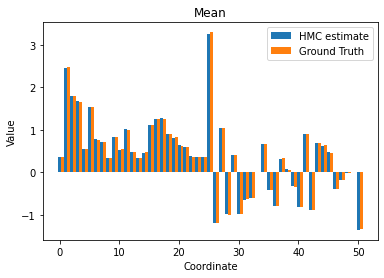

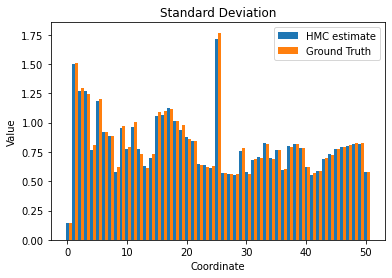

In [0]:
identity_fn = target.sample_transformations['identity']
x_chain_transformed = identity_fn(x_chain)
x_mean = x_chain_transformed[num_steps//2:].mean((0, 1))
x_stddev = x_chain_transformed[num_steps//2:].std((0, 1))
plt.figure()
plt.title('Mean')
plt.bar(jnp.arange(x_map_transformed.shape[-1]), x_mean, 0.5, label='HMC estimate')
plt.bar(0.5 + jnp.arange(x_map_transformed.shape[-1]), identity_fn.ground_truth_mean, 0.5, label='Ground Truth')
plt.ylabel('Value')
plt.xlabel('Coordinate')
plt.legend()

plt.figure()
plt.title('Standard Deviation')
plt.bar(jnp.arange(x_map_transformed.shape[-1]), x_stddev, 0.5, label='HMC estimate')
plt.bar(0.5 + jnp.arange(x_map_transformed.shape[-1]), identity_fn.ground_truth_standard_deviation, 0.5, label='Ground Truth')
plt.ylabel('Value')
plt.xlabel('Coordinate')
plt.legend();

Looks pretty good. This gives us some evidence towards claiming that we've implemented HMC correctly, and that it works well on this problem.

# Conclusion

In this tutorial we introduced the Inference Gym, its `Model` class API, and how to write a basic inference method around a specific model. Note that the API was designed such that it's easy to write a generic inference algorithm. This colab was written in a such a generic way, so we encourage you to try it with some other model (although remember that you'll need to to adjust the HMC hyperparameters).

 We hope that the Inference Gym can be useful for researchers who want a standard set of benchmark problems to validate their inference algorithms against.

Inference Gym is an affiliated project to TensorFlow Probability. If you want additional help or want to file a bug or a feature request use the [TensorFlow Probability GitHub project](https://github.com/tensorflow/probability) or the [mailing list](https://groups.google.com/a/tensorflow.org/g/tfprobability).

# Appendix A: `BayesianModel` class.

Inference Gym is primarily focused on *black box* inference, where the inference algorithm does not exploit the structure of the model. Currently there is limited support for so-called "Bayesian models", where the log-density is the posterior distribution of some model. Such models derive from the `BayesianModel` class. Let us take a look at a simple example.

In [0]:
target = gym.targets.EightSchools()

In addition to all the properties discussed in the main body of the tutorial, instances of the `BayesianModel` class also expose the prior distribution (an instance of the TensorFlow Probability's `Distribution` class) and the log-likelihood function:

In [0]:
prior_distribution = target.prior_distribution()
log_likelihood_fn = target.log_likelihood

We can sample from the prior, which can be used to initialize some inference algorithms. We can also evaluate the normalized log-density of the prior:

In [0]:
x = prior_distribution.sample(seed=jax.random.PRNGKey(1))
print(x)
lp = prior_distribution.log_prob(x)
print(lp)

{'log_stddev': DeviceArray(6.282736, dtype=float32), 'avg_effect': DeviceArray(-1.6169955, dtype=float32), 'school_effects': DeviceArray([  64.43103,  152.7646 ,   70.7264 , -213.1018 , -196.92476,
              637.2468 ,  311.98535, -112.0647 ], dtype=float32)}
-63.697857


The likelihood can be evaluated (and differentiated via autodiff) at points in the model's support.

In [0]:
log_likelihood_fn(x)

DeviceArray(-2711.4683, dtype=float32)

We hope this explicit structure will help writing inference algortihms that can exploit this factorization of the model.

# Appendix B: Using `tfp.mcmc` to do inference.

The TensorFlow Probability library provides black-box inference methods that can be used to perform inference on the Inference Gym models. Here we'll use the `tfp.mcmc` library to do adaptive HMC on the model.

In [0]:
target = gym.targets.BrownianMotionMissingMiddleObservations()

In [0]:
print(type(target).__doc__)
print(super(type(target), target).__doc__)

A simple Brownian Motion with 30 timesteps where 10 are unobservable.
Construct the Brownian Motion model.

  This models a Brownian Motion process with a Gaussian observation model.

  ```none
  locs[0] ~ Normal(loc=0, scale=innovation_noise_scale)
  for t in range(1, num_timesteps):
    locs[t] ~ Normal(loc=locs[t - 1], scale=innovation_noise_scale)

  for t in range(num_timesteps):
    observed_locs[t] ~ Normal(loc=locs[t], scale=observation_noise_scale)
  ```

  This model supports missing observations, indicated by NaNs in the
  `observed_locs` parameter.
  


In [0]:
target = gym.targets.VectorModel(target,
                                 flatten_sample_transformations=True)

In [0]:
import tensorflow_probability.substrates.jax as tfp

In [0]:
num_chains = 4
num_steps = 4000
init_step_size = 0.01

# Set up HMC. Note that it computes gradients automatically.
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target.unnormalized_log_prob,
    step_size=init_step_size,
    num_leapfrog_steps=1)
# Adapt step size.
hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    hmc,  
    num_adaptation_steps=int(num_steps // 2 * 0.8),
    target_accept_prob=0.9)
# Adapt trajectory length.
hmc = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(
    hmc,
    num_adaptation_steps=int(num_steps // 2 * 0.8))
# Constrain the sampler to the model support
hmc = tfp.mcmc.TransformedTransitionKernel(
    hmc,
    bijector=target.default_event_space_bijector)

from tensorflow_probability.python.internal.unnest import get_innermost

def trace_fn(_, pkr):
  return (
      get_innermost(pkr, 'is_accepted'),
      get_innermost(pkr, 'log_accept_ratio') < -1000,
      get_innermost(pkr, 'step_size'),
      get_innermost(pkr, 'max_trajectory_length'))

z_init = jnp.zeros([num_chains] + target.default_event_space_bijector.inverse_event_shape(target.event_shape),
                   dtype=target.dtype)
x_init = target.default_event_space_bijector(z_init)
x_chain, (is_accepted, diverged,
          step_size, max_trajectory_length) = tfp.mcmc.sample_chain(
    current_state=x_init,
    kernel=hmc,
    num_results=num_steps,
    trace_fn=trace_fn,
    seed=jax.random.PRNGKey(0))

In [0]:
# This will take awhile because JAX stages computation asynchronously.
print('P(accept)', is_accepted[num_steps//2:].mean())
print('num divergences', diverged[num_steps//2:].sum())

P(accept) 0.899125
num divergences 0


Since `tfp.mcmc` code above is performing adaptive MCMC, we should check out whether the learned hyperparameters converged.

Text(0.5, 0, 'step')

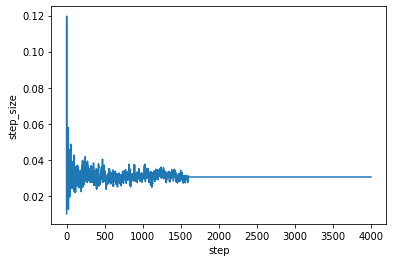

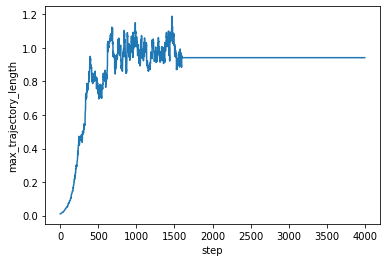

In [0]:
plt.figure()
plt.plot(step_size)
plt.ylabel('step_size')
plt.xlabel('step')
plt.figure()
plt.plot(max_trajectory_length)
plt.ylabel('max_trajectory_length')
plt.xlabel('step')

Looks like both hyperparameters converged. Let's use Arviz to do some diagnostics on the chains.

In [0]:
# Arviz expects traces to have the shape[num_chains, num_steps, num_dims], so
# we need to do a transpose. We'll also discard the first half of the samples
# for warmup.

az_data = az.from_dict(
    posterior=dict(x=x_chain[num_steps//2:].transpose((1, 0, 2))),
    sample_stats=dict(diverging=diverged[num_steps//2:].transpose((1, 0))),
)

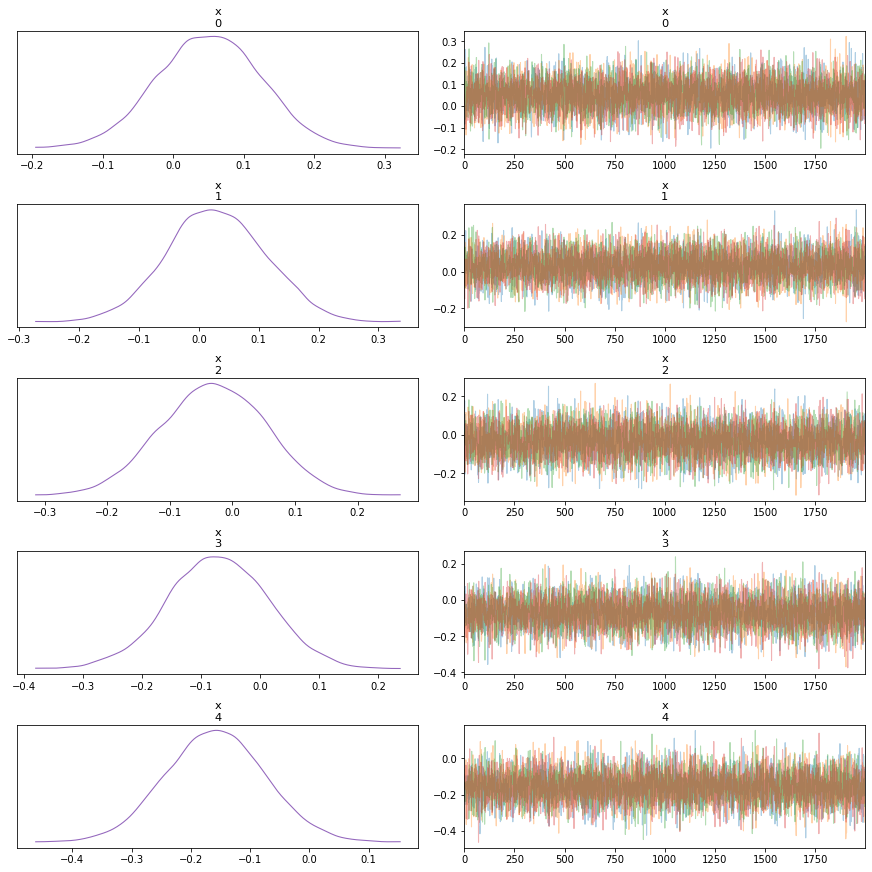

In [0]:
interesting_dims = {'x_dim_0': [0, 1, 2, 3, 4]}
az.plot_trace(az_data, combined=True, compact=False, coords=interesting_dims, figsize=(12, 12));

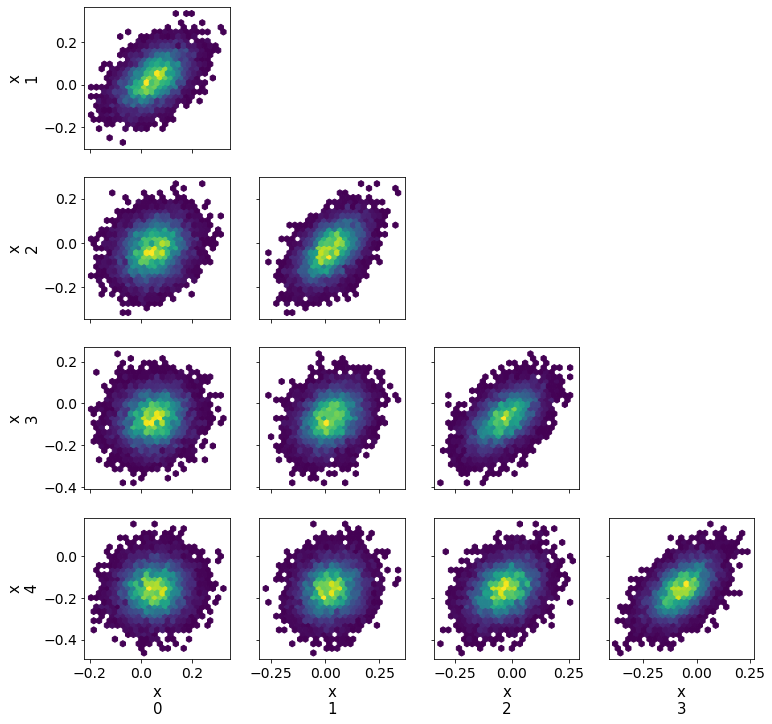

In [0]:
az.plot_pair(az_data, coords=interesting_dims, kind='hexbin', figsize=(12, 12), gridsize=25, divergences=True);

In [0]:
az.summary(az_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],0.051,0.074,-0.083,0.193,0.001,0.001,7012.0,5730.0,1.0
x[1],0.029,0.081,-0.124,0.178,0.001,0.001,6731.0,6423.0,1.0
x[2],-0.031,0.083,-0.189,0.121,0.001,0.001,6366.0,6125.0,1.0
x[3],-0.072,0.084,-0.229,0.092,0.001,0.001,6536.0,6047.0,1.0
x[4],-0.159,0.084,-0.311,0.004,0.001,0.001,6429.0,6248.0,1.0
x[5],-0.193,0.086,-0.350,-0.031,0.001,0.001,6323.0,5484.0,1.0
x[6],-0.248,0.085,-0.408,-0.089,0.001,0.001,6392.0,5587.0,1.0
x[7],-0.264,0.085,-0.413,-0.096,0.001,0.001,6470.0,6118.0,1.0
x[8],-0.298,0.088,-0.468,-0.140,0.001,0.001,6689.0,6343.0,1.0
x[9],-0.268,0.100,-0.458,-0.078,0.001,0.001,6412.0,5412.0,1.0


Everything looks fine. Lastly, let's check out the bias.

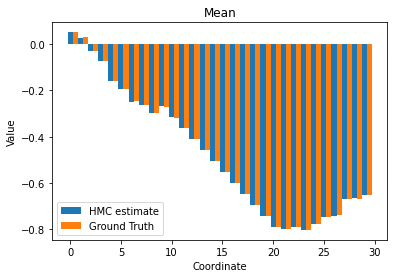

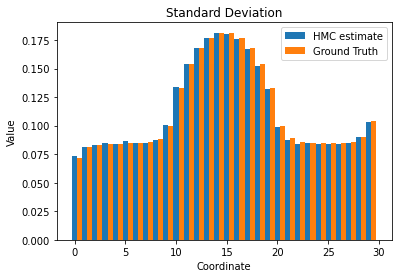

In [0]:
identity_fn = target.sample_transformations['identity']
x_chain_transformed = identity_fn(x_chain)
x_mean = x_chain_transformed[num_steps//2:].mean((0, 1))
x_stddev = x_chain_transformed[num_steps//2:].std((0, 1))
plt.figure()
plt.title('Mean')
plt.bar(jnp.arange(x_chain_transformed.shape[-1]), x_mean, 0.5, label='HMC estimate')
plt.bar(0.5 + jnp.arange(x_chain_transformed.shape[-1]), identity_fn.ground_truth_mean, 0.5, label='Ground Truth')
plt.ylabel('Value')
plt.xlabel('Coordinate')
plt.legend()

plt.figure()
plt.title('Standard Deviation')
plt.bar(jnp.arange(x_chain_transformed.shape[-1]), x_stddev, 0.5, label='HMC estimate')
plt.bar(0.5 + jnp.arange(x_chain_transformed.shape[-1]), identity_fn.ground_truth_standard_deviation, 0.5, label='Ground Truth')
plt.ylabel('Value')
plt.xlabel('Coordinate')
plt.legend();